In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import yaml

from transformer import *
from hybrid_loss import *
from model import *
from evaluation import *
from conformer import *

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

## Final Performance Analysis Notebook for 1D Flash Detection
### Actual calculations are old - `performance_analysis.py` is updated script
### Still using to load files & plot

**Model Versions:**
* Enumerate model versions to test in `model_list.yaml`

**Single Flash Statistics (Performance Upper Bounds)**
* Accuracy vs. # Photons
* Purity vs. # Photons
* Predicted Interval Width vs. # Photons
* Reconstructed # Photons vs. # Photons

**Double Flash Statistics**
* Accuracy PER FLASH vs. Photon Ratio
* Reconstructed # Photons PER FLASH vs. Photon Ratio
* Purity vs. Photon Ratio
* Accuracy PER FLASH vs. Delta T
* Reconstructed # Photons PER FLASH vs. Delta T
* Purity vs. Delta T

In [9]:
device='cuda'

MODEL_CLASSES = {
    "TransformerModel": TransformerModel,
    "ConformerModel": ConformerModel,
    "ConformerModelv2": ConformerModelv2,
    "UNet1D": UNet1D
}

def load_models(config_path, device="cuda"):
    with open(config_path, "r") as f:
        configs = yaml.safe_load(f)

    models = {}
    for name, cfg in configs.items():
        if not cfg.get("include", True):
            continue
            
        print(name)
        cls = MODEL_CLASSES[cfg["class"]]
        model = cls(**cfg.get("args", {}))
        model.to(device)

        checkpoint = torch.load(cfg["checkpoint"], map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()

        models[name] = model
    return models
    
models = load_models("model_list.yaml")
print(models.keys())  

conformer_v5_drop
dict_keys(['conformer_v5_drop'])


/lscratch/carsmith/tmp/ipykernel_3050237/1474617615.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cfg["checkpoint"], map_location=device)


### Single Flash Statistics Data

In [16]:
# Data sample for single-flashes
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/1delayphot_reg.npy', allow_pickle=True)
print(load_wfs)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list

merge_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



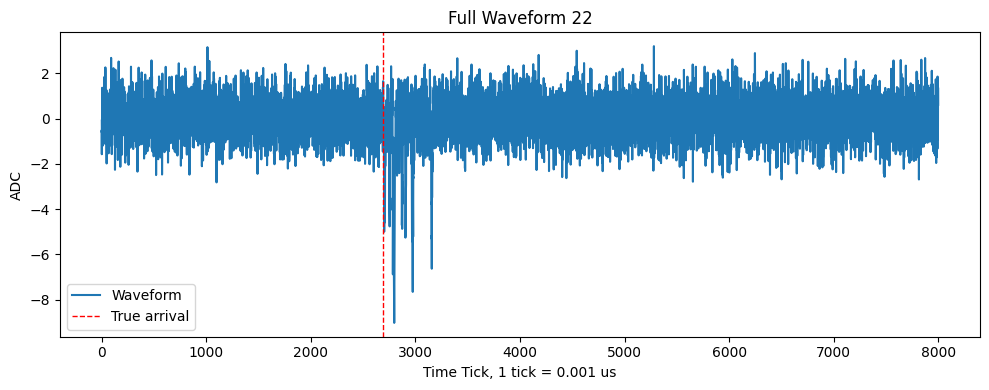

In [20]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(merge_loader))
ticks = np.arange(waveforms[0].shape[1])
waveform_id = 22
wf = waveforms[waveform_id]
ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]
plt.figure(figsize = (10, 4))
plt.plot(ticks, wf, alpha=1, label='Waveform')

for j, t in enumerate(hit_times[waveform_id]):
    if t < 0:
        pass
    else:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )
        
plt.title(f"Full Waveform {waveform_id}")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

### Resolution Study
1. Average interval width
2. On average, how many ns after start of window does true hit fall?

In [48]:
models = {
    "conformer_mlp": model,
    "transformer_2M": transformer_2M
}

# First, bin by # photons
bin_width = 100
batches_per_photon = 4
single_p_int_stats = {name: {"interval": [], "offset": []} for name in models.keys()}

epoch = 0
epochs = 1
acc_progress = tqdm(merge_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

interval_bins = {name: [] for name in models.keys()}
offsets = {name: [] for name in models.keys()}

with torch.no_grad():
    for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
        data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

        # loop through all models in dict
        for name, model in models.items():
            class_output, reg_output = model(data, mode="bce")
            merged_mask = merge_bins(class_output, skip_tol=5)

            # interval widths
            for b in range(merged_mask.shape[0]):
                mask_row = merged_mask[b, 0]
                intervals = mask_to_intervals(mask_row)
                widths = [(e - s + 1) for (s, e) in intervals]
                interval_bins[name].extend(widths)

                # offsets
                true_hits = hit_times[b]
                
                for (s, e) in intervals:
                    hits_in_interval = [h for h in true_hits if s <= h <= e]
                    if len(hits_in_interval) > 0:
                        for h in hits_in_interval:
                            # print(f"s={s}, e={e}, h={h}")
                            offset = h - s
                            offsets[name].append(offset.item())
                            width = e - s + 1
                            if offset > width:
                                print(f"WARNING: offset {offset} > width {width}, s={s}, e={e}, h={h}")

        if (i + 1) % batches_per_photon == 0:
            for name in models.keys():
                avg_offset = np.mean(offsets[name]) if offsets[name] else 0.0
                avg_interval = np.mean(interval_bins[name]) if interval_bins[name] else 0.0

                single_p_int_stats[name]["interval"].append(avg_interval)
                single_p_int_stats[name]["offset"].append(offsets[name])
                
                # reset accumulators
                interval_bins[name] = []
                offsets[name] =[]
                
np.save('test.npy', single_p_int_stats, allow_pickle=True)

['conformer_mlp', 'transformer_2M']


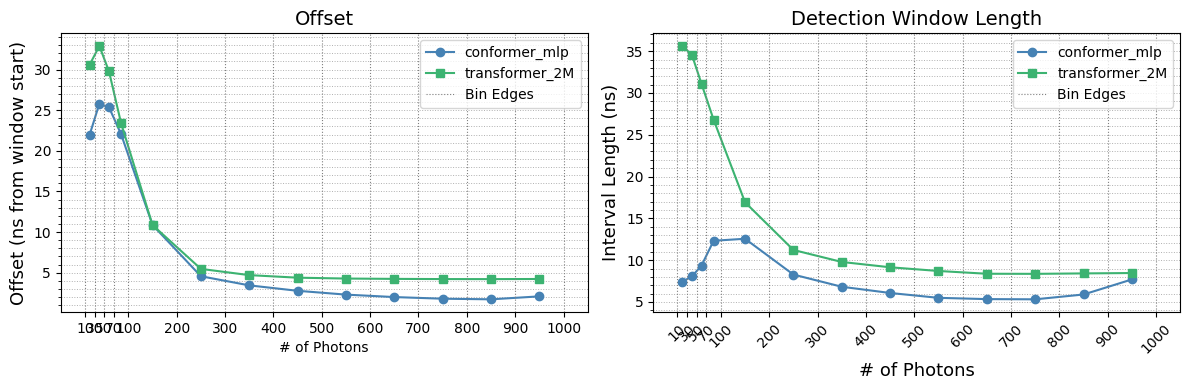

In [49]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator

all_results = np.load("test.npy", allow_pickle=True).item()
model_names = list(all_results.keys())   # ['tr', 'unet']
print(model_names)

colors = ["steelblue", "mediumseagreen", "orange", "red", "purple"]
markers = ["o", "s", "D", "v", "^"]
# model_names = ['unet', 'tr_215', 'conformer_50', 'conformer_5M', 'transformer_2M']

# Convert each model's data into arrays
model_offset = {
    name: np.array([np.mean(x) for x in all_results[name]["offset"]])
    for name in model_names
}
# model_offset = {name: np.array(all_results[name]["offset"]) for name in model_names}
model_interval = {name: np.array(all_results[name]["interval"]) for name in model_names}

# Define binning
bin_size = 100
ref_data_shape = 990
bin_sizes = [20, 20, 20, 30] + [bin_size] * (990 // bin_size)
bin_edges = np.cumsum([10] + bin_sizes)
bin_centers = bin_edges[:-1] + (np.array(bin_sizes) / 2)

def bin_data(arr, bin_sizes):
    """Average data into bins of variable width."""
    out, start = [], 0
    for b in bin_sizes:
        out.append(arr[start:start+b].mean())
        start += b
    return np.array(out)

# Create 1x2 plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axes = axes.flatten()

# -------- Plot offset --------
ax = axes[0]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_offset[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

# Bin edges
for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

ax.set_xlabel("# of Photons")
ax.set_ylabel("Offset (ns from window start)", fontsize=13)
ax.set_title("Offset", fontsize=14)
ax.set_xticks(bin_edges)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot interval --------
ax = axes[1]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_interval[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

# Bin edges
for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Interval Length (ns)", fontsize=13)
ax.set_title("Detection Window Length", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
for name in model_names:
    print(name, [np.shape(x) for x in all_results[name]["offset"][:10]])

### Rest of Single Flash Stats

In [13]:
bin_width = 100
batches_per_photon = 4

# Put all models you want to evaluate in a dict
single_phot_results = {name: {"interval": [], "reco_frac": [], "merge_acc": [], "merge_pure": []} for name in models.keys()}
epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(merge_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

    # temporary accumulators
    interval_bins = {name: [] for name in models.keys()}
    reco_frac = {name: 0.0 for name in models.keys()}
    merged_acc = {name: 0.0 for name in models.keys()}
    merged_pure = {name: 0.0 for name in models.keys()}

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            # loop through all models in dict
            for name, model in models.items():
                class_output, reg_output = model(data, mode="bce")
                merged_mask = merge_bins(class_output, skip_tol=5)

                # interval widths
                for b in range(merged_mask.shape[0]):
                    mask_row = merged_mask[b, 0]
                    intervals = mask_to_intervals(mask_row)
                    widths = [(e - s + 1) for (s, e) in intervals]
                    interval_bins[name].extend(widths)

                # summed photons per interval
                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)

                pred = torch.tensor([np.sum(x) for x in interval_pred_sums])
                true = torch.tensor([np.sum(x) for x in interval_true_sums])
                mask = true > 0
                if mask.any():
                    reco_frac[name] += torch.mean(pred[mask] / true[mask]).item()

                merged_acc[name] += merged_class_acc(merged_mask, hit_times, device)
                merged_pure[name] += merged_class_purity(merged_mask, hit_times, device)

            # record stats once per photon bin
            if (i + 1) % batches_per_photon == 0:
                for name in models.keys():
                    reco_frac[name] /= batches_per_photon
                    merged_acc[name] /= batches_per_photon
                    merged_pure[name] /= batches_per_photon
                    
                    avg_interval = np.mean(interval_bins[name]) if interval_bins[name] else 0.0

                    single_phot_results[name]["interval"].append(avg_interval)
                    single_phot_results[name]["reco_frac"].append(reco_frac[name])
                    single_phot_results[name]["merge_acc"].append(merged_acc[name])
                    single_phot_results[name]["merge_pure"].append(merged_pure[name])

                    # reset accumulators
                    interval_bins[name] = []
                    reco_frac[name] = 0.0
                    merged_acc[name] = 0.0
                    merged_pure[name] = 0.0

np.save("reduced_overfit_confs_singlepstats.npy", single_phot_results, allow_pickle=True)

In [ ]:
pwd

In [10]:
### Accumulating All Results
### Accumulating All Results
unet_results = np.load("performance_analysis/singleflash_eval_stats.npy", allow_pickle=True).item() #UNet, tr_215
c5M_t2M_results = np.load("performance_analysis/c5M_t2M_singlephot_stats.npy", allow_pickle=True).item() #conformer5M, transformer2M
c_195K_results = np.load("performance_analysis/conform_trans5x_singlephot_stats.npy", allow_pickle=True).item() #conformer195K
less_overfit_con_results = np.load("performance_analysis/reduced_overfit_confs_singlepstats.npy", allow_pickle=True).item()
con_mlp_results = np.load("performance_analysis/con_mlp_singlephot.npy", allow_pickle=True).item() #conformer195K
conv3_results = np.load("performance_analysis/conv3_e34_singleflash_results.npy", allow_pickle=True).item()
conv5_mse_results = np.load("performance_analysis/con_v5mse_v5+_singleflash_nomerge.npy", allow_pickle=True).item()
# all_results = {**unet_results, **c5M_t2M_results, **c_195K_results, **con_mlp_results}
all_results = {**unet_results, **c5M_t2M_results, **less_overfit_con_results, **conv3_results, **conv5_mse_results, **c_195K_results}

model_names = list(all_results.keys())   # ['tr', 'unet']
# model_names.remove('tr_160')
# model_names.remove('tr_215')
print(model_names)

['tr_160', 'tr_215', 'unet', 'conformer_5M', 'transformer_2M', 'conformer_v2', 'conformer_v5_drop', 'conformer_v5', 'conformer_v3', 'conformer_v5_+', 'conformer_30', 'conformer_50', 'transformer_5x_40']


(990,)


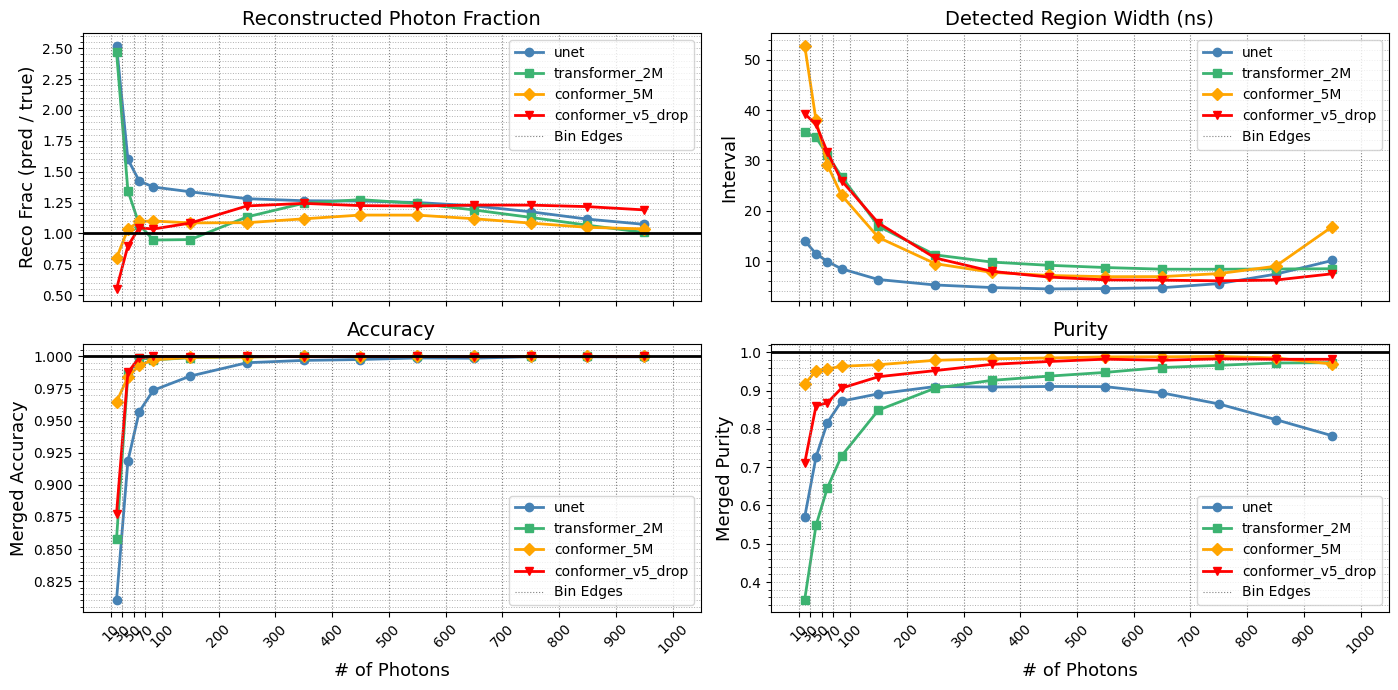

In [11]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
# model_names = ['unet', 'tr_215', 'transformer_2M', 'conformer_v5_drop']
model_names = ['unet', 'transformer_2M', 'conformer_5M', 'conformer_v5_drop']
# colors = ["steelblue", "mediumseagreen", "orange", "red", "purple", "darkblue", "pink"]
colors = ["steelblue", "mediumseagreen", "orange", "red", "darkblue", "pink", "darkslategrey", "darkblue", "gray"]

markers = ["o", "s", "D", "v", "^", "o", "s"]
#model_names = ['unet', 'conformer_5M', 'transformer_2M', 'conformer_mlp']

# Convert each model's data into arrays
model_reco_frac = {name: np.array(all_results[name]["reco_frac"]) for name in model_names}
model_interval = {name: np.array(all_results[name]["interval"]) for name in model_names}
model_acc = {name: np.array(all_results[name]["merge_acc"]) for name in model_names}
model_pure = {name: np.array(all_results[name]["merge_pure"]) for name in model_names}

# Define binning
bin_size = 100
ref_data = next(iter(model_reco_frac.values()))  # reference length
print(ref_data.shape)
bin_sizes = [20, 20, 20, 30] + [bin_size] * (len(ref_data) // bin_size)
bin_edges = np.cumsum([10] + bin_sizes)
bin_centers = bin_edges[:-1] + (np.array(bin_sizes) / 2)

def bin_data(arr, bin_sizes):
    """Average data into bins of variable width."""
    out, start = [], 0
    for b in bin_sizes:
        out.append(arr[start:start+b].mean())
        start += b
    return np.array(out)

# Create 1x2 plot
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()
# -------- Plot reco_frac --------
ax = axes[0]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_reco_frac[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

# Bin edges
for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
# ax.set_xlabel("# of Photons")
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_ylabel("Reco Frac (pred / true)", fontsize=13)
ax.set_title("Reconstructed Photon Fraction", fontsize=14)
ax.set_xticks(bin_edges)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
# ax.grid(axis="y")
ax.legend()

# -------- Plot interval --------
ax = axes[1]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_interval[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

# ax.set_xlabel("# of Photons")
ax.set_ylabel("Interval", fontsize=13)
ax.set_title("Detected Region Width (ns)", fontsize=14)
ax.set_xticks(bin_edges)
# ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Accuracy --------
ax = axes[2]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_acc[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Accuracy", fontsize=13)
ax.set_title("Accuracy", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Purity --------
ax = axes[3]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_pure[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker, linewidth=2)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Purity", fontsize=13)
ax.set_title("Purity", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

plt.tight_layout()
plt.show()

### Double Flash (Delta T) Statistics

In [12]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delayed_delta_t/delta_t_100phot.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

delta_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

In [13]:
print(f"Batches: {len(delta_loader)}")

Batches: 4000


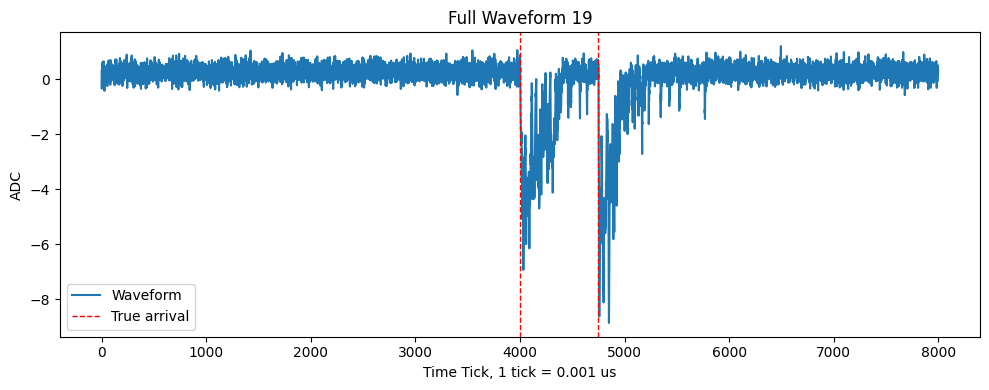

In [14]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(delta_loader))
ticks = np.arange(waveforms[0].shape[1])
waveform_id = np.random.randint(0, 25, 1)[0]
wf = waveforms[waveform_id]
ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]
plt.figure(figsize = (10, 4))
plt.plot(ticks, wf, alpha=1, label='Waveform')

for j, t in enumerate(hit_times[waveform_id]):
    if t < 0:
        pass
    else:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )
        
plt.title(f"Full Waveform {waveform_id}")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

### Ratios - Not Useful, Stopped Using This

In [ ]:
bin_width = 100
batches_per_photon = 400

models = {
    "tr_160": transformer_160,
    "tr_170": transformer_170,
    "unet": unet_50
}

results = {
    name: {"reco_frac_flash1": [], "reco_frac_flash2": [], "merge_acc_flash1": [], "merge_acc_flash2": [], "merge_pure": []}
    for name in models.keys()
}

epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(
        delta_loader,
        desc=f"Scanning {epoch+1}/{epochs}",
        leave=False,
        position=0
    )

    # Temporary accumulators for per-photon-bin averages
    reco_frac_flash1 = {name: 0.0 for name in models.keys()}
    reco_frac_flash2 = {name: 0.0 for name in models.keys()}
    merge_acc_flash1 = {name: 0.0 for name in models.keys()}
    merge_acc_flash2 = {name: 0.0 for name in models.keys()}
    merge_pure = {name: 0.0 for name in models.keys()}

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            # loop through all models
            for name, model in models.items():
                if name == "tr":
                    class_output, reg_output = model(data, mode="bce")
                else:
                    class_output, reg_output = model(data)

                merged_mask = merge_bins(class_output, skip_tol=5)

                # Summed Photons per Interval
                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)

                pred = torch.tensor([np.sum(x) for x in interval_pred_sums])
                true = torch.tensor([np.sum(x) for x in interval_true_sums])
                mask = true > 0
                # if mask.any():
                if mask.sum() >= 2:  # make sure at least two flashes survived got detected
                    valid_idx = torch.where(mask)[0]
                    reco_frac_flash1[name] += (pred[valid_idx[0]] / true[valid_idx[0]]).item()
                    reco_frac_flash2[name] += (pred[valid_idx[1]] / true[valid_idx[1]]).item()

                # Merging metrics
                flash1_acc, flash2_acc = merged_twoflash_acc(merged_mask, hit_times, device)
                merge_acc_flash1[name] += flash1_acc
                merge_acc_flash2[name] += flash2_acc

                merge_pure[name] += merged_class_purity(merged_mask, hit_times, device)

            # Record stats once per photon bin
            if (i + 1) % batches_per_photon == 0:
                for name in models.keys():
                    reco_frac_flash1[name] /= batches_per_photon
                    reco_frac_flash2[name] /= batches_per_photon
                    merge_acc_flash1[name] /= batches_per_photon
                    merge_acc_flash2[name] /= batches_per_photon
                    merge_pure[name] /= batches_per_photon

                    results[name]["reco_frac_flash1"].append(reco_frac_flash1[name])
                    results[name]["reco_frac_flash2"].append(reco_frac_flash2[name])
                    results[name]["merge_acc_flash1"].append(merge_acc_flash1[name])
                    results[name]["merge_acc_flash2"].append(merge_acc_flash2[name])
                    results[name]["merge_pure"].append(merge_pure[name])

                    # reset accumulators
                    reco_frac_flash1[name] = 0.0
                    reco_frac_flash2[name] = 0.0
                    merge_acc_flash1[name] = 0.0
                    merge_acc_flash2[name] = 0.0
                    merge_pure[name] = 0.0

np.save("test_ratiostats.npy", results, allow_pickle=True)

In [ ]:
print(results['tr']['merge_acc_flash1'])

In [ ]:
results = np.load("test_ratiostats.npy", allow_pickle=True).item()
ratios = ["(0.1,0.2)", "(0.2,0.5)", "(0.5,1.0)", "(1.0,2.0)",
          "(2.0,5.0)", "(5.0,7.0)", "(7.0,10.0)"]
ticks = np.arange(len(ratios))

metrics = {
    "Flash Accuracies": ["merge_acc_flash1", "merge_acc_flash2"],
    # "Purity": ["merge_pure"],
    "Reco Fraction": ["reco_frac_flash1", "reco_frac_flash2"],
}

flash_colors = {
    "flash1": "steelblue",
    "flash2": "darkblue",
    "default": "black",   # for metrics without flash
}

markers = ["o", "s", "D", "v", "^"]

n_models = len(results.keys())
n_metrics = len(metrics)

fig, axes = plt.subplots(
    n_models, n_metrics, figsize=(6 * n_metrics, 2.5 * n_models), sharex=True
)

# Ensure axes is 2D
if n_models == 1:
    axes = np.expand_dims(axes, axis=0)
if n_metrics == 1:
    axes = np.expand_dims(axes, axis=1)

for row_idx, (model_name, model_data) in enumerate(results.items()):
    for col_idx, (title, metric_keys) in enumerate(metrics.items()):
        ax = axes[row_idx, col_idx]
        marker = markers[row_idx % len(markers)]

        for m in metric_keys:  # one or two metrics per subplot
            arr = np.array(model_data[m])
            if m.endswith("flash1"):
                color = flash_colors["flash1"]
                label_suffix = "Flash 1"
            elif m.endswith("flash2"):
                color = flash_colors["flash2"]
                label_suffix = "Flash 2"
            else:
                color = flash_colors["default"]
                label_suffix = ""
            ax.plot(
                ticks, arr,
                marker=marker,
                color=color,
                label=f"{model_name} {label_suffix}" if label_suffix else f"{model_name}"
            )

        if row_idx == 0:
            ax.set_title(title, fontsize=14)
        ax.legend()
        ax.set_xticks(ticks)
        ax.set_xticklabels(ratios, rotation=0)

        if col_idx == 0:
            ax.set_ylabel(model_name, fontsize=12)  # row labels are model names

plt.tight_layout()
plt.show()

In [ ]:
# Plotting purity on one plot
ratios = ["(0.1,0.2)", "(0.2,0.5)", "(0.5,1.0)", "(1.0,2.0)",
          "(2.0,5.0)", "(5.0,7.0)", "(7.0,10.0)"]
ticks = np.arange(len(ratios))
model_names = ['tr_160', 'tr_170', 'unet']

for name in model_names:  # safer to use your defined order
    plt.plot(ticks, results[name]['merge_pure'], marker='o', label=name)

plt.legend()
plt.title("Merged Purity vs. Photon Ratios")
plt.xticks(ticks, ratios, rotation=0)  # <-- pass labels here
plt.xlabel("Photon Ratios")             # <-- axis label
plt.ylabel("Purity")
plt.tight_layout()
plt.show()

### Delta T

In [16]:
def aggregate_bins(delta_results, bin_size=1):
    """
    Aggregate results into coarser bins.
    bin_size = number of indices to merge (e.g. 10 for 10 ns bins).
    Uses mean over bins.
    """
    agg_results = {}

    for model, metrics in delta_results.items():
        agg_results[model] = {}
        n_bins = len(next(iter(metrics.values())))

        # Number of new bins after aggregation
        n_new = n_bins // bin_size
        new_bins = np.arange(n_new) * bin_size

        for key, arr in metrics.items():
            arr = np.array(arr)
            # truncate so it's divisible by bin_size
            arr = arr[:n_new * bin_size]
            arr = arr.reshape(n_new, bin_size).mean(axis=1)
            agg_results[model][key] = arr

        # Store new bin centers
        agg_results[model]["bin_centers"] = new_bins + bin_size / 2

    return agg_results

In [15]:
print(models.keys())

dict_keys(['conformer_v5_drop'])


In [64]:
# Delta T buckets
'''
In dataloader, samples are sorted by photon ratio
But, we can re-arrange with delta t: hit_times[1] - hit_times[0]
For now, collect stats by 1 ns binning, but we can aggregate later
'''
bin_width = 100


delta_results = {
    name: {
        "bin_counts": torch.zeros(1501),
        "reco_frac_flash1": torch.zeros(1501),
        "reco_frac_flash2": torch.zeros(1501),
        "merge_acc_flash1": torch.zeros(1501),
        "merge_acc_flash2": torch.zeros(1501),
        "merge_pure": torch.zeros(1501)
    }
    for name in models.keys()
}

epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(delta_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            indices = torch.tensor([int(t[1] - t[0]) for t in hit_times], dtype=torch.long)

            for name, model in models.items():
                class_output, reg_output = model(data)

                merged_mask = merge_bins(class_output, skip_tol=5) # 1's for predicted regions, 0's for non-predicted regions

                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)# [[], [], []]
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)

                flash1_acc_ls, flash2_acc_ls = merged_twoflash_acc(merged_mask, hit_times, device, no_sum=True)
                purity_ls = merged_class_purity(merged_mask, hit_times, device, no_sum=True)

                for b, idx in enumerate(indices):
                    delta_results[name]["bin_counts"][idx] += 1

                    mask = np.array(interval_true_sums[b]) > 0
                    valid_idx = np.where(mask)

                    if len(valid_idx[0]) >= 2:
                        delta_results[name]["reco_frac_flash1"][idx] += (interval_pred_sums[b][valid_idx[0][0]] / interval_true_sums[b][valid_idx[0][0]]).item()
                        delta_results[name]["reco_frac_flash2"][idx] += (interval_pred_sums[b][valid_idx[0][1]] / interval_true_sums[b][valid_idx[0][1]]).item()

                    delta_results[name]["merge_acc_flash1"][idx] += flash1_acc_ls[b]
                    delta_results[name]["merge_acc_flash2"][idx] += flash2_acc_ls[b]
                    delta_results[name]["merge_pure"][idx] += purity_ls[b]

# Normalize by per-model bin counts
for name in models.keys():
    counts = delta_results[name]["bin_counts"].clone()
    counts[counts == 0] = 1  # prevent division by zero
    for key in delta_results[name]:
        if key != "bin_counts":
            delta_results[name][key] /= counts

np.save("delta_t_50phot.npy", delta_results, allow_pickle=True)

In [7]:
print(models.keys())

dict_keys(['conformer_v5_drop'])


### Investigating Reco Frac > 1 Asymptote

In [110]:
delta_results = {
    name: {
        "bin_counts": torch.zeros(1501),
        "reco_frac_flash1": torch.zeros(1501),
        "reco_frac_flash2": torch.zeros(1501),
        "merge_acc_flash1": torch.zeros(1501),
        "merge_acc_flash2": torch.zeros(1501),
        "merge_pure": torch.zeros(1501)
    }
    for name in models
}

epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(delta_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            indices = torch.tensor([int(t[1] - t[0]) for t in hit_times], dtype=torch.long)

            for name, model in models.items():
                name = 'conformer_v5_drop'
                if name == "tr":
                    class_output, reg_output = model(data, mode="bce")
                else:
                    class_output, reg_output = model(data)

                merged_mask = merge_bins(class_output, skip_tol=5)

                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)# [[], [], []]
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)
                
                flash1_acc_ls, flash2_acc_ls = merged_twoflash_acc(merged_mask, hit_times, device, no_sum=True)
                purity_ls = merged_class_purity(merged_mask, hit_times, device, no_sum=True)

                for b, idx in enumerate(indices):
                    delta_results[name]["bin_counts"][idx] += 1

                    mask = np.array(interval_true_sums[b]) > 0
                    valid_idx = np.where(mask)

                    if len(valid_idx[0]) >= 2:
                        delta_results[name]["reco_frac_flash1"][idx] += (interval_pred_sums[b][valid_idx[0][0]] / interval_true_sums[b][valid_idx[0][0]]).item()
                        delta_results[name]["reco_frac_flash2"][idx] += (interval_pred_sums[b][valid_idx[0][1]] / interval_true_sums[b][valid_idx[0][1]]).item()

                    delta_results[name]["merge_acc_flash1"][idx] += flash1_acc_ls[b]
                    delta_results[name]["merge_acc_flash2"][idx] += flash2_acc_ls[b]
                    delta_results[name]["merge_pure"][idx] += purity_ls[b]
                break
            if i == 5:
                break

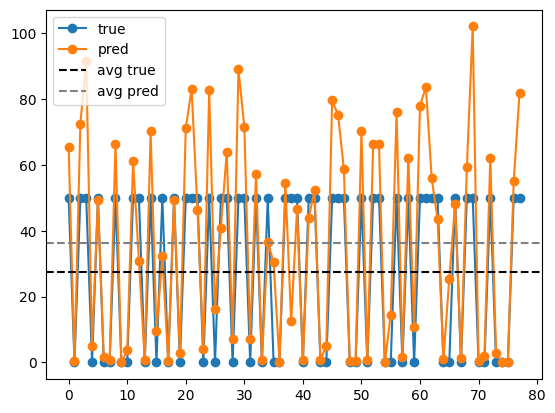

In [111]:
flat_true = [float(x) for sublist in interval_true_sums for x in sublist]  # flatten
flat_pred = [float(x) for sublist in interval_pred_sums for x in sublist]  # flatten

plt.plot(np.array(flat_true), marker = 'o', label='true')
plt.plot(np.array(flat_pred), marker = 'o', label='pred')
plt.axhline(np.mean(flat_true), linestyle = '--', color='black', label = 'avg true')
plt.axhline(np.mean(flat_pred), linestyle = '--', color='gray', label = 'avg pred')
plt.legend()

### Combined Delta T Plots

In [67]:
delta_results = np.load("delta_t_50phot.npy", allow_pickle=True).item()
# print(delta_results['unet']["reco_frac_flash1"])

['tr_160', 'tr_180', 'unet', 'tr_215', 'conformer_30', 'conformer_50', 'transformer_5x_40', 'conformer_5M', 'transformer_2M', 'conformer_v2', 'conformer_v5_drop', 'conformer_v5', 'conformer_v3', 'conformer_v5_+']
['unet', 'tr_215', 'conformer_50', 'transformer_2M', 'conformer_v2', 'conformer_v5_drop', 'conformer_v5', 'conformer_v3', 'conformer_v5_+']
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure'])


/lscratch/carsmith/tmp/ipykernel_3050237/377841884.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(arr)


tr_160
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
tr_180
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
unet
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
tr_215
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
conformer_30
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
conformer_50
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
transformer_5x_40
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', '

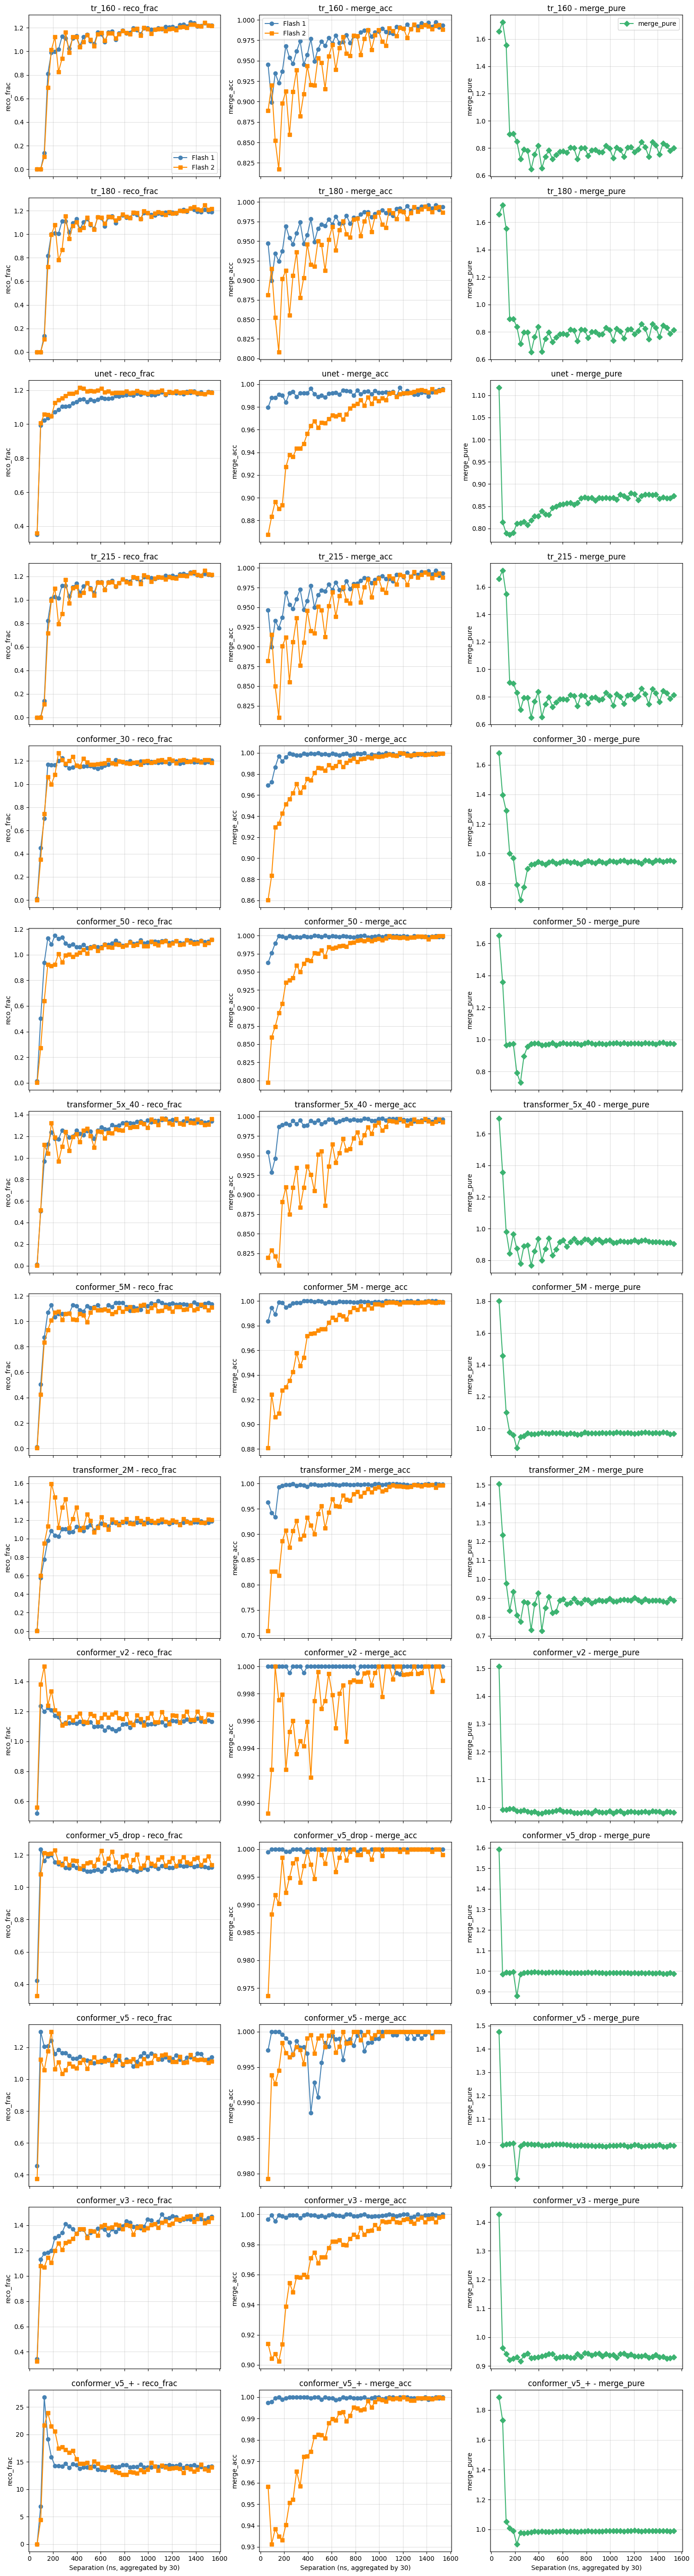

In [17]:
# Load saved results
delta_results = np.load("performance_analysis/deltastats_3trans_100k.npy", allow_pickle=True).item()
conformer_delta_results = np.load("performance_analysis/deltastats_conformers_trans5M_100k.npy", allow_pickle=True).item()
c5M_t2M_delta_results = np.load("performance_analysis/c5M_t2M_deltastats.npy", allow_pickle=True).item()
tr215_delta_results = np.load("performance_analysis/t215_deltastats.npy", allow_pickle=True).item()
less_overfit_conformer_results = np.load("performance_analysis/less_overfit_con_500deltas.npy", allow_pickle=True).item()
conv3_results = np.load("performance_analysis/conv3_e34_delta_random_results.npy", allow_pickle=True).item()
conv5_results = np.load("performance_analysis/conv5_pos_nomerge_delta_stats.npy", allow_pickle=True).item()


all_delta_results = {**delta_results, **tr215_delta_results, **conformer_delta_results, **c5M_t2M_delta_results, **less_overfit_conformer_results, **conv3_results, **conv5_results}

model_names = list(all_delta_results.keys())   # ['tr', 'unet']
print(model_names)
model_names.remove('tr_160')
model_names.remove('tr_180')
model_names.remove('conformer_30')
model_names.remove('transformer_5x_40')
model_names.remove('conformer_5M')
print(model_names)
print(all_delta_results['unet'].keys())

# Aggregate bins (change bin_size=10 for 10 ns bins, etc.)
bin_size = 30
all_delta_results = aggregate_bins(all_delta_results, bin_size=bin_size)
models = all_delta_results.keys()

paired_metrics = {
    "reco_frac": ("reco_frac_flash1", "reco_frac_flash2"),
    "merge_acc": ("merge_acc_flash1", "merge_acc_flash2"),
}
single_metrics = ["merge_pure"]

ncols = len(paired_metrics) + len(single_metrics)
nrows = len(models)

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True)

if nrows == 1:
    axes = np.expand_dims(axes, 0)

colors = ["steelblue", "darkorange"]

for row, model in enumerate(models):
    print(model)
    results = all_delta_results[model]
    print(results.keys())
    bin_centers = results['bin_centers'] + 50

    # ---- Paired metrics ----
    for col, (metric_name, (flash1_key, flash2_key)) in enumerate(paired_metrics.items()):
        ax = axes[row, col]
        ax.plot(bin_centers, results[flash1_key], label=f"Flash 1", color=colors[0], marker="o")
        ax.plot(bin_centers, results[flash2_key], label=f"Flash 2", color=colors[1], marker="s")

        ax.set_title(f"{model} - {metric_name}")
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.4)

        if row == nrows - 1:
            ax.set_xlabel(f"Separation (ns, aggregated by {bin_size})")
        if row == 0:
            ax.legend()

    # ---- Single metrics ----
    for j, metric_name in enumerate(single_metrics):
        col = len(paired_metrics) + j
        ax = axes[row, col]
        ax.plot(bin_centers, results[metric_name], label=metric_name, color="mediumseagreen", marker="D")

        ax.set_title(f"{model} - {metric_name}")
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.4)

        if row == nrows - 1:
            ax.set_xlabel(f"Separation (ns, aggregated by {bin_size})")
        if row == 0:
            ax.legend()

plt.tight_layout()
plt.show()

['unet', 'transformer_2M', 'conformer_5M', 'conformer_v2']


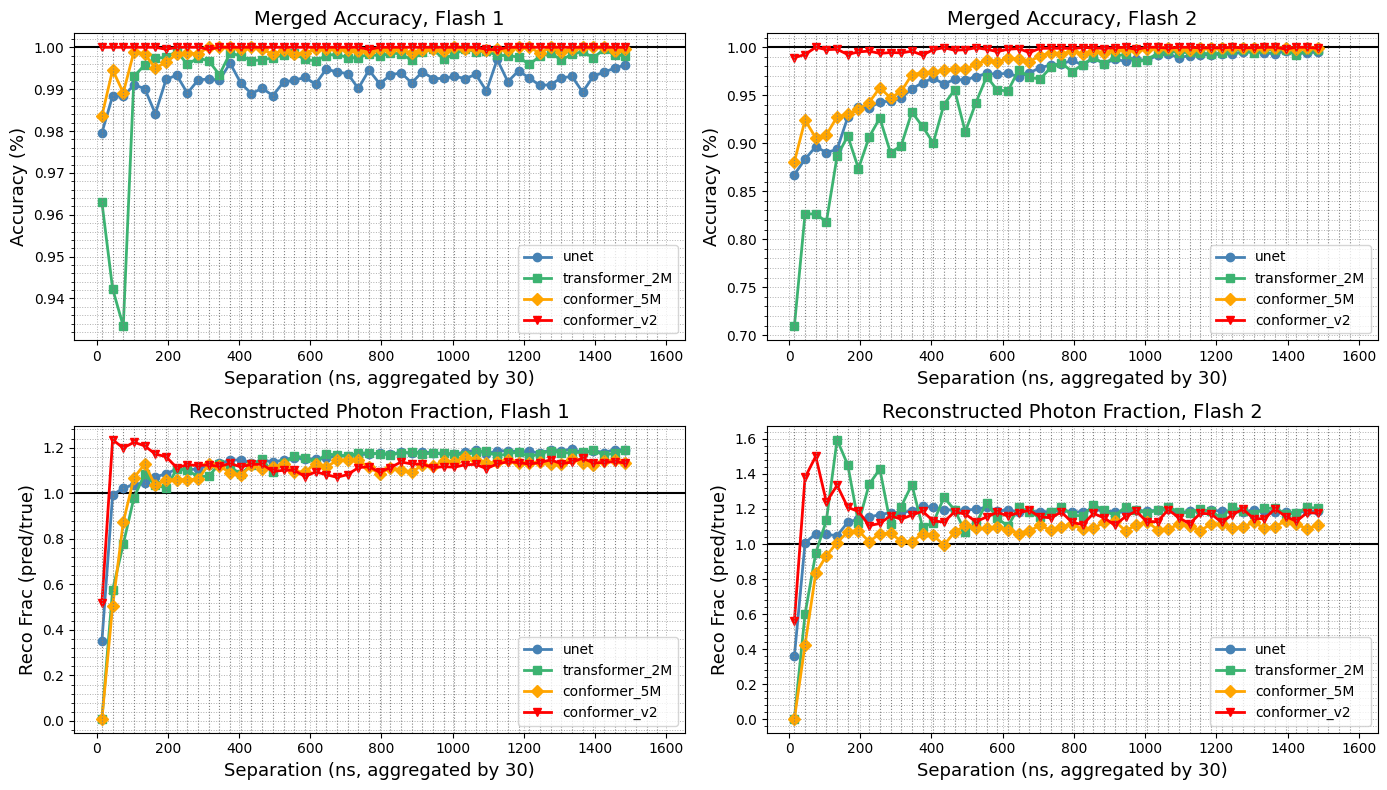

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
model_names = ['unet', 'transformer_2M', 'conformer_5M', 'conformer_v2']
fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # 2 rows, 2 cols
axes = axes.ravel()  # flatten into 1D array for easy indexing
# colors = ["steelblue", "mediumseagreen", "orange", "red", "purple", "pink", "darkslategrey", "darkblue", "gray"]
colors = ["steelblue", "mediumseagreen", "orange", "red", "red", "pink", "darkslategrey", "darkblue", "gray"]
markers = ["o", "s", "D", "v", "^", "o", "s", "o", "D"]
print(model_names)
# --- Top left: Accuracy Flash 1 ---
ax = axes[0]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['merge_acc_flash1'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Merged Accuracy, Flash 1", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Accuracy (%)", fontsize=13)

# --- Top right: Accuracy Flash 2 ---
ax = axes[1]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['merge_acc_flash2'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Merged Accuracy, Flash 2", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Accuracy (%)", fontsize=13)

# --- Bottom left: Reco Fraction Flash 1 ---
ax = axes[2]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['reco_frac_flash1'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Reconstructed Photon Fraction, Flash 1", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Reco Frac (pred/true)", fontsize=13)

# --- Bottom right: Reco Fraction Flash 2 ---
ax = axes[3]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['reco_frac_flash2'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Reconstructed Photon Fraction, Flash 2", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Reco Frac (pred/true)", fontsize=13)

# Layout
plt.tight_layout()
plt.show()

### Regression Loss vs. Binned Averages

In [3]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import yaml

from transformer import *
from hybrid_loss import *
from model import *
from evaluation import *
from conformer import *

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

# Load Analysis Config
with open("../performance_analysis_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Load Models
device='cuda'

MODEL_CLASSES = {
    "TransformerModel": TransformerModel,
    "ConformerModel": ConformerModel,
    "ConformerModelv2": ConformerModelv2,
    "UNet1D": UNet1D
}

models = load_models("model_list.yaml", MODEL_CLASSES)
print(models.keys())

conformer_v5_drop


/sdf/home/c/carsmith/flash_reconstruction/flash_detection/notebooks/../data_utils.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cfg["checkpoi

dict_keys(['conformer_v5_drop'])


In [20]:
bool_values = [v for v in config["double_flash"].values() if isinstance(v, bool)]
if any(bool_values):

    delta_name = config["double_flash"]["fixed_photon"]
    delta_loader = make_dataloader(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delayed_delta_t/delta_t_{delta_name}phot.npy", seed=42, batch_size=25, shuffle=False)
    print("Delta Loader Length: ", len(delta_loader))
    
    delta_results = {
        name: {
            "bin_counts": torch.zeros(1501),
            "reco_frac_flash1": torch.zeros(1501),
            "reco_frac_flash2": torch.zeros(1501),
            "reco_frac_total": torch.zeros(1501),
            "reg_loss": torch.zeros(1501),
            "reg_loss_0.8pred": torch.zeros(1501),
            "merge_acc_flash1": torch.zeros(1501),
            "merge_acc_flash2": torch.zeros(1501),
            "merge_pure": torch.zeros(1501)
        }
        for name in models.keys()
    }
    epochs = 1
    flash1_acc_ls = np.zeros(delta_loader.batch_size)
    flash2_acc_ls = np.zeros(delta_loader.batch_size)
    purity_ls = np.zeros(delta_loader.batch_size)

    regression_criterion = torch.nn.PoissonNLLLoss(log_input=True)
    
    for epoch in range(epochs):
        acc_progress = tqdm(delta_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)
    
        with torch.no_grad():
            for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
                data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)
    
                indices = torch.tensor([int(t[1] - t[0]) for t in hit_times], dtype=torch.long)
    
                for name, (model, reg_loss_type) in models.items():
                    predict_fn = torch.expm1 if reg_loss_type == 'mse' else torch.exp
        
                    class_output, reg_output = model(data, mode="bce")
                    merged_mask = merge_bins(class_output, skip_tol=5)
        
                    # regression loss per sample
                    mask = (torch.sigmoid(class_output) > 0.5).squeeze(1)
                    masked_reg_output = reg_output.squeeze(1)[mask]
                    masked_photon_target = photon_target.squeeze(1)[mask]

                    loss_vals = torch.zeros(data.size(0), device=device)
                    loss_vals_08 = torch.zeros(data.size(0), device=device)
                    
                    for b in range(data.size(0)):
                        mask_b = (torch.sigmoid(class_output[b]) > 0.5).squeeze(0)  # mask for sample b
                        reg_out_b = reg_output[b].squeeze(0)[mask_b]
                        target_b = photon_target.squeeze(1)[b][mask_b]
                
                        if reg_out_b.numel() > 0:
                            loss_vals[b] = regression_criterion(reg_out_b, target_b)  # [num_masked_bins]
                            loss_vals_08[b] = regression_criterion(reg_out_b*0.8, target_b)
        
                    # now accumulate bin results
                    for b, idx in enumerate(indices):
                        delta_results[name]["bin_counts"][idx] += 1
                        delta_results[name]["reg_loss"][idx] += loss_vals[b].item()
                        delta_results[name]["reg_loss_0.8pred"][idx] += loss_vals_08[b].item()
    
                        if config["double_flash"]["reco_frac"]:
                            mask = np.array(interval_true_sums[b]) > 0
                            valid_idx = np.where(mask)
                            if len(valid_idx[0]) >= 2:
                                delta_results[name]["reco_frac_flash1"][idx] += (interval_pred_sums[b][valid_idx[0][0]] / interval_true_sums[b][valid_idx[0][0]]).item()
                                delta_results[name]["reco_frac_flash2"][idx] += (interval_pred_sums[b][valid_idx[0][1]] / interval_true_sums[b][valid_idx[0][1]]).item()
                                delta_results[name]["reco_frac_total"][idx] += sum(interval_pred_sums[b]) / sum(interval_true_sums[b])
                        delta_results[name]["merge_acc_flash1"][idx] += flash1_acc_ls[b]
                        delta_results[name]["merge_acc_flash2"][idx] += flash2_acc_ls[b]
                        delta_results[name]["merge_pure"][idx] += purity_ls[b]
    
    for name in models.keys():
        counts = delta_results[name]["bin_counts"].clone()
        counts[counts == 0] = 1  # prevent division by zero
        for key in delta_results[name]:
            if key != "bin_counts":
                delta_results[name][key] /= counts
    
    # np.save("notebooks/performance_analysis/test.npy", delta_results, allow_pickle=True)

Delta Loader Length:  4000


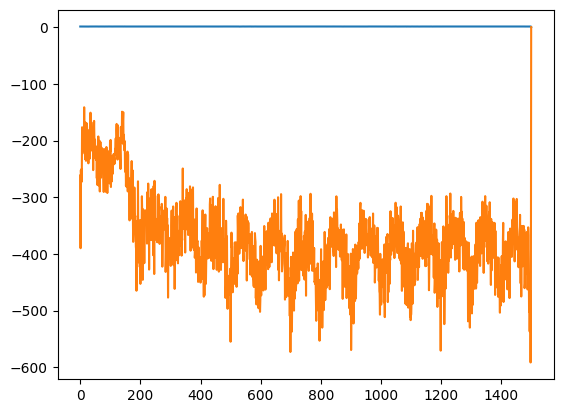

In [21]:
plt.plot(delta_results[name]['reco_frac_total'])
plt.plot(delta_results[name]['reg_loss'])